In [66]:
# Global Constants (Place this at the very top of your notebook, e.g., in Cell 1)
ROLLING_WINDOW = 10
EWMA_SPAN = 10
H2H_RECENT_WINDOW = 3
ROLLING_DERIVED_COLS = [
    'is_winner', # Now consistently included in this list
    '1st_serve_in_pct', '1st_serve_win_pct',
    '2nd_serve_win_pct', # Corrected typo: '2nd_serve_win_pct'
    'break_point_save_pct', 'total_pts_won_on_serve_pct', 'break_pct'
]

In [67]:
# Cell 1: Import Libraries

import pandas as pd
from sklearn.model_selection import train_test_split
# No RandomForestClassifier import here, as we're using NN
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np # Added for handling inf/NaN in derived stats

# TensorFlow and Keras imports (NEW)
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

print("Libraries imported successfully!")


Libraries imported successfully!


In [68]:
# Cell 2: Load and Concatenate Raw Data

# Directory where all ATP match CSVs are saved
data_path = '../tennis_atp/'  # Update if your path is different

# List of years you want to include
years = list(range(2010, 2025))

# Load and concatenate all relevant files
dfs = []
for year in years:
    file = os.path.join(data_path, f'atp_matches_{year}.csv')
    if os.path.exists(file):
        # Load CSV without 'format' or 'errors' arguments for read_csv (for older Pandas compatibility)
        df_year = pd.read_csv(file)
        dfs.append(df_year)
    else:
        print(f"Warning: File not found for year {year} at {file}")

# Combine all years into one DataFrame
df_all = pd.concat(dfs, ignore_index=True)

# Convert 'tourney_date' to datetime objects AFTER concatenation
# Specify the format here, as 'format' and 'errors' are valid for pd.to_datetime
df_all['tourney_date'] = pd.to_datetime(df_all['tourney_date'], format='%Y%m%d', errors='coerce')

# Sort by date and match_num to ensure chronological order for rolling calculations
df_all = df_all.sort_values(by=['tourney_date', 'match_num']).reset_index(drop=True)

print(f"Loaded {len(df_all)} total ATP matches from {years[0]} to {years[-1]}")
print("First 5 rows of combined data (with tourney_date as datetime):")
display(df_all.head())
print("\nData types after parsing date:")
display(df_all.info())
print(f"NaN count in df_all (before any processing): \n{df_all.isnull().sum().loc[lambda x : x > 0]}")

Loaded 42571 total ATP matches from 2010 to 2024
First 5 rows of combined data (with tourney_date as datetime):


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,2010-01-03,1,104053,1.0,NaN,...,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,2010-01-03,2,104958,NaN,WC,...,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,2010-01-03,3,104755,NaN,NaN,...,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0
3,2010-339,Brisbane,Hard,32,A,2010-01-03,4,105051,NaN,Q,...,29.0,16.0,15.0,9.0,2.0,5.0,285.0,151.0,28.0,1260.0
4,2010-339,Brisbane,Hard,32,A,2010-01-03,5,104607,4.0,NaN,...,41.0,26.0,14.0,9.0,6.0,9.0,20.0,1655.0,251.0,179.0



Data types after parsing date:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42571 entries, 0 to 42570
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tourney_id          42571 non-null  object        
 1   tourney_name        42571 non-null  object        
 2   surface             42518 non-null  object        
 3   draw_size           42571 non-null  int64         
 4   tourney_level       42571 non-null  object        
 5   tourney_date        42571 non-null  datetime64[ns]
 6   match_num           42571 non-null  int64         
 7   winner_id           42571 non-null  int64         
 8   winner_seed         18166 non-null  float64       
 9   winner_entry        5668 non-null   object        
 10  winner_name         42571 non-null  object        
 11  winner_hand         42571 non-null  object        
 12  winner_ht           42080 non-null  float64       
 13  winner_ioc    

None

NaN count in df_all (before any processing): 
surface                  53
winner_seed           24405
winner_entry          36903
winner_ht               491
winner_age                3
loser_seed            32329
loser_entry           33418
loser_hand                4
loser_ht               1100
loser_age                 3
minutes                4383
w_ace                  2742
w_df                   2742
w_svpt                 2742
w_1stIn                2742
w_1stWon               2742
w_2ndWon               2742
w_SvGms                2742
w_bpSaved              2742
w_bpFaced              2742
l_ace                  2742
l_df                   2742
l_svpt                 2742
l_1stIn                2742
l_1stWon               2742
l_2ndWon               2742
l_SvGms                2742
l_bpSaved              2742
l_bpFaced              2742
winner_rank             262
winner_rank_points      262
loser_rank              671
loser_rank_points       671
dtype: int64


In [69]:
# Cell 3: Create Player-Centric Records for Rolling Statistics Calculation

# Define stats columns we'll want to average for players
player_stats_cols_raw = [
    'winner_age', 'winner_ht', 'winner_rank', 'winner_rank_points',
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
    'w_SvGms', 'w_bpSaved', 'w_bpFaced',
    'loser_age', 'loser_ht', 'loser_rank', 'loser_rank_points',
    'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon',
    'l_SvGms', 'l_bpSaved', 'l_bpFaced'
]

# Create records for the winner
df_winners = df_all[['tourney_date', 'surface', 'match_num', 'winner_id', 'winner_name', 'loser_id', 'loser_name', 'score', 'best_of', 'round', 'minutes']].copy()
df_winners = df_winners.rename(columns={'winner_id': 'player_id', 'winner_name': 'player_name',
                                        'loser_id': 'opponent_id', 'loser_name': 'opponent_name'})
df_winners['is_winner'] = 1 # Mark as winner

# Add winner's match stats and opponent's stats to winner's row
for col in player_stats_cols_raw:
    if col.startswith('w_'):
        df_winners[col.replace('w_', 'player_')] = df_all[col]
    elif col.startswith('winner_'):
        df_winners[col.replace('winner_', 'player_')] = df_all[col]
    elif col.startswith('l_'):
        df_winners[col.replace('l_', 'opponent_')] = df_all[col]
    elif col.startswith('loser_'):
        df_winners[col.replace('loser_', 'opponent_')] = df_all[col]

# Create records for the loser
df_losers = df_all[['tourney_date', 'surface', 'match_num', 'loser_id', 'loser_name', 'winner_id', 'winner_name', 'score', 'best_of', 'round', 'minutes']].copy()
df_losers = df_losers.rename(columns={'loser_id': 'player_id', 'loser_name': 'player_name',
                                      'winner_id': 'opponent_id', 'winner_name': 'opponent_name'})
df_losers['is_winner'] = 0 # Mark as loser

# Add loser's match stats and opponent's stats to loser's row
for col in player_stats_cols_raw:
    if col.startswith('l_'):
        df_losers[col.replace('l_', 'player_')] = df_all[col]
    elif col.startswith('loser_'):
        df_losers[col.replace('loser_', 'player_')] = df_all[col]
    elif col.startswith('w_'):
        df_losers[col.replace('w_', 'opponent_')] = df_all[col]
    elif col.startswith('winner_'):
        df_losers[col.replace('winner_', 'opponent_')] = df_all[col]

# Combine player records
player_df = pd.concat([df_winners, df_losers], ignore_index=True)
player_df['tourney_date'] = pd.to_datetime(player_df['tourney_date'], format='%Y%m%d')
player_df = player_df.sort_values(by=['player_id', 'tourney_date']).reset_index(drop=True)


# --- NEW ADDITION: Handle NaNs in raw player stats before derived calculations ---
raw_stat_cols = [
    'player_age', 'player_ht', 'player_rank', 'player_rank_points',
    'player_ace', 'player_df', 'player_svpt', 'player_1stIn', 'player_1stWon', 'player_2ndWon',
    'player_SvGms', 'player_bpSaved', 'player_bpFaced',
    'opponent_age', 'opponent_ht', 'opponent_rank', 'opponent_rank_points',
    'opponent_ace', 'opponent_df', 'opponent_svpt', 'opponent_1stIn', 'opponent_1stWon', 'opponent_2ndWon',
    'opponent_SvGms', 'opponent_bpSaved', 'opponent_bpFaced'
]

print("\n--- Handling NaNs in raw player and opponent stats (Cell 3) ---")
for col in raw_stat_cols:
    if col in player_df.columns:
        if 'rank' in col:
            player_df[col] = player_df[col].fillna(9999).astype(float)
        elif 'age' in col or 'ht' in col:
            player_df[col] = player_df[col].fillna(player_df[col].median()).astype(float)
        else:
            player_df[col] = player_df[col].fillna(0).astype(float)
    else:
        print(f"Warning: Raw stat column '{col}' not found in player_df. Skipping NaN handling for it.")

# Handle 'minutes' and 'surface' separately if they have NaNs
if 'minutes' in player_df.columns:
    player_df['minutes'] = player_df['minutes'].fillna(player_df['minutes'].median()).astype(float)
if 'surface' in player_df.columns:
    player_df['surface'] = player_df['surface'].fillna('Unknown')


# Calculate derived features for each match (before rolling averages)
player_df['1st_serve_in_pct'] = player_df['player_1stIn'] / player_df['player_svpt']
player_df['1st_serve_win_pct'] = player_df['player_1stWon'] / player_df['player_1stIn']
player_df['2nd_serve_win_pct'] = player_df['player_2ndWon'] / (player_df['player_svpt'] - player_df['player_1stIn'])
player_df['total_pts_won_on_serve_pct'] = (player_df['player_1stWon'] + player_df['player_2ndWon']) / player_df['player_svpt']

player_df['break_point_save_pct'] = player_df['player_bpSaved'] / player_df['player_bpFaced']
player_df['break_points_converted'] = player_df['opponent_bpFaced'] - player_df['opponent_bpSaved']
player_df['break_pct'] = player_df['break_points_converted'] / player_df['opponent_svpt']


# Handle division by zero or NaN results from derived stats
for col in ['1st_serve_in_pct', '1st_serve_win_pct', '2nd_serve_win_pct',
            'break_point_save_pct', 'total_pts_won_on_serve_pct', 'break_pct']:
    player_df[col] = player_df[col].replace([np.inf, -np.inf], np.nan)
    player_df[col] = player_df[col].fillna(0).astype(float)


print(f"Created {len(player_df)} player-centric records.")
print("First 5 rows of player_df (with new derived stats and initial NaN handling):")
display(player_df.head())
print(f"NaN count in player_df (after initial derived stats and fillna in Cell 3): \n{player_df.isnull().sum().loc[lambda x : x > 0]}")

print("\n--- DIAGNOSTIC: Columns in player_df after concatenation (Cell 3) ---")
print(player_df.columns.tolist())
print("\n--- DIAGNOSTIC: Head of player_df for base player attributes (Cell 3) ---")
display(player_df[['player_id', 'tourney_date', 'player_rank', 'player_age', 'player_ht', 'player_rank_points',
                   'player_ace', 'player_svpt', 'player_1stIn', 'player_1stWon', 'player_2ndWon',
                   'opponent_rank', 'opponent_age', 'opponent_ht', 'opponent_rank_points',
                   'opponent_ace', 'opponent_svpt', 'opponent_1stIn', 'opponent_1stWon', 'opponent_2ndWon']].head())
print("\n--- DIAGNOSTIC: NaN counts for base player attributes (Cell 3) ---")
print(player_df[['player_rank', 'player_age', 'player_ht', 'player_rank_points',
                   'player_ace', 'player_svpt', 'player_1stIn', 'player_1stWon', 'player_2ndWon',
                   'opponent_rank', 'opponent_age', 'opponent_ht', 'opponent_rank_points',
                   'opponent_ace', 'opponent_svpt', 'opponent_1stIn', 'opponent_1stWon', 'opponent_2ndWon']].isnull().sum())


--- Handling NaNs in raw player and opponent stats (Cell 3) ---
Created 85142 player-centric records.
First 5 rows of player_df (with new derived stats and initial NaN handling):


,tourney_date,surface,match_num,player_id,player_name,opponent_id,opponent_name,score,best_of,round,...,opponent_SvGms,opponent_bpSaved,opponent_bpFaced,1st_serve_in_pct,1st_serve_win_pct,2nd_serve_win_pct,total_pts_won_on_serve_pct,break_point_save_pct,break_points_converted,break_pct
0,2013-07-15,Clay,6,100644,Alexander Zverev,105138,Roberto Bautista Agut,6-3 6-2,3,R64,...,9.0,6.0,9.0,0.358974,0.500000,0.240000,0.333333,0.250000,3.0,0.053571
1,2014-04-28,Clay,4,100644,Alexander Zverev,103781,Jurgen Melzer,6-1 6-2,3,R32,...,8.0,6.0,7.0,0.454545,0.450000,0.333333,0.386364,0.285714,1.0,0.021277
2,2014-07-07,Clay,8,100644,Alexander Zverev,104586,Lukas Rosol,7-6(7) 7-6(9),3,R32,...,12.0,1.0,3.0,0.580645,0.648148,0.615385,0.634409,0.500000,2.0,0.023256
3,2014-07-14,Clay,8,100644,Alexander Zverev,104898,Robin Haase,6-0 6-2,3,R64,...,7.0,4.0,9.0,0.568182,0.680000,0.789474,0.727273,1.000000,5.0,0.096154
4,2014-07-14,Clay,24,100644,Alexander Zverev,104022,Mikhail Youzhny,7-5 7-5,3,R32,...,12.0,7.0,11.0,0.467532,0.694444,0.560976,0.623377,0.600000,4.0,0.046512


NaN count in player_df (after initial derived stats and fillna in Cell 3): 
Series([], dtype: int64)

--- DIAGNOSTIC: Columns in player_df after concatenation (Cell 3) ---
['tourney_date', 'surface', 'match_num', 'player_id', 'player_name', 'opponent_id', 'opponent_name', 'score', 'best_of', 'round', 'minutes', 'is_winner', 'player_age', 'player_ht', 'player_rank', 'player_rank_points', 'player_ace', 'player_df', 'player_svpt', 'player_1stIn', 'player_1stWon', 'player_2ndWon', 'player_SvGms', 'player_bpSaved', 'player_bpFaced', 'opponent_age', 'opponent_ht', 'opponent_rank', 'opponent_rank_points', 'opponent_ace', 'opponent_df', 'opponent_svpt', 'opponent_1stIn', 'opponent_1stWon', 'opponent_2ndWon', 'opponent_SvGms', 'opponent_bpSaved', 'opponent_bpFaced', '1st_serve_in_pct', '1st_serve_win_pct', '2nd_serve_win_pct', 'total_pts_won_on_serve_pct', 'break_point_save_pct', 'break_points_converted', 'break_pct']

--- DIAGNOSTIC: Head of player_df for base player attributes (Cell 3) ---


,player_id,tourney_date,player_rank,player_age,player_ht,player_rank_points,player_ace,player_svpt,player_1stIn,player_1stWon,player_2ndWon,opponent_rank,opponent_age,opponent_ht,opponent_rank_points,opponent_ace,opponent_svpt,opponent_1stIn,opponent_1stWon,opponent_2ndWon
0,100644,2013-07-15,798.0,16.2,198.0,20.0,1.0,39.0,14.0,7.0,6.0,49.0,25.2,183.0,872.0,2.0,56.0,42.0,25.0,9.0
1,100644,2014-04-28,765.0,17.0,198.0,25.0,1.0,44.0,20.0,9.0,8.0,66.0,32.9,183.0,700.0,2.0,47.0,30.0,24.0,9.0
2,100644,2014-07-07,285.0,17.2,198.0,163.0,6.0,93.0,54.0,35.0,24.0,48.0,28.9,193.0,900.0,5.0,86.0,54.0,43.0,16.0
3,100644,2014-07-14,285.0,17.2,198.0,163.0,3.0,44.0,25.0,17.0,15.0,51.0,27.2,191.0,865.0,1.0,52.0,34.0,17.0,5.0
4,100644,2014-07-14,285.0,17.2,198.0,163.0,0.0,77.0,36.0,25.0,23.0,19.0,32.0,183.0,1735.0,1.0,86.0,46.0,25.0,21.0



--- DIAGNOSTIC: NaN counts for base player attributes (Cell 3) ---
player_rank             0
player_age              0
player_ht               0
player_rank_points      0
player_ace              0
player_svpt             0
player_1stIn            0
player_1stWon           0
player_2ndWon           0
opponent_rank           0
opponent_age            0
opponent_ht             0
opponent_rank_points    0
opponent_ace            0
opponent_svpt           0
opponent_1stIn          0
opponent_1stWon         0
opponent_2ndWon         0
dtype: int64


In [70]:
# Cell 4: Calculate Rolling Averages for each player (General, EWMA, Surface-Specific, H2H, and New Features)

# Ensure player_df is sorted by player_id and tourney_date for correct general rolling calculations
player_df = player_df.sort_values(by=['player_id', 'tourney_date']).reset_index(drop=True)

# --- 1. Shift 'current' player attributes to become 'previous' attributes ---
print("Calculating 'previous' player attributes (rank, age, height, rank_points)...")
for attr in ['player_rank', 'player_rank_points', 'player_age', 'player_ht']:
    if attr in player_df.columns:
        player_df[f'{attr.replace("player_", "player_prev_")}'] = \
            player_df.groupby('player_id')[attr].transform(lambda x: x.shift(1)).astype(float)
    else:
        print(f"Warning: Base column '{attr}' not found in player_df. Skipping 'player_prev_' creation for it.")
        player_df[f'{attr.replace("player_", "player_prev_")}'] = np.nan


# --- 2. General Rolling Averages (including 'is_winner') ---
print(f"Calculating general rolling averages over last {ROLLING_WINDOW} matches...")
for col in ROLLING_DERIVED_COLS:
    if col in player_df.columns:
        player_df[f'player_avg_{col}_last{ROLLING_WINDOW}'] = player_df.groupby('player_id')[col].transform(
            lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean().shift(1)
        ).astype(float)
    else:
        print(f"Warning: Base column '{col}' not found for general rolling average. Skipping.")
        player_df[f'player_avg_{col}_last{ROLLING_WINDOW}'] = np.nan


# --- 3. NEW: Exponentially Weighted Moving Averages (EWMA) (including 'is_winner') ---
print(f"Calculating EWMA over span={EWMA_SPAN} for general stats...")
for col in ROLLING_DERIVED_COLS:
    if col in player_df.columns:
        player_df[f'player_ewma_{col}_span{EWMA_SPAN}'] = player_df.groupby('player_id')[col].transform(
            lambda x: x.ewm(span=EWMA_SPAN, adjust=False, min_periods=1).mean().shift(1)
        ).astype(float)
    else:
        print(f"Warning: Base column '{col}' not found for EWMA. Skipping.")
        player_df[f'player_ewma_{col}_span{EWMA_SPAN}'] = np.nan


# --- 4. NEW: Surface-Specific Rolling Averages (Existing + EWMA) (including 'is_winner') ---
print(f"Calculating surface-specific rolling averages over last {ROLLING_WINDOW} matches on that surface...")
print(f"Calculating surface-specific EWMA over span={EWMA_SPAN} on that surface...")
for col in ROLLING_DERIVED_COLS:
    if col in player_df.columns and 'surface' in player_df.columns:
        # Rolling mean on surface
        player_df[f'player_avg_{col}_on_surface_last{ROLLING_WINDOW}'] = player_df.groupby(['player_id', 'surface'])[col].transform(
            lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean().shift(1)
        ).astype(float)
        # EWMA on surface
        player_df[f'player_ewma_{col}_on_surface_span{EWMA_SPAN}'] = player_df.groupby(['player_id', 'surface'])[col].transform(
            lambda x: x.ewm(span=EWMA_SPAN, adjust=False, min_periods=1).mean().shift(1)
        ).astype(float)
    else:
        print(f"Warning: Base column '{col}' or 'surface' not found for surface-specific stats. Skipping.")
        player_df[f'player_avg_{col}_on_surface_last{ROLLING_WINDOW}'] = np.nan
        player_df[f'player_ewma_{col}_on_surface_span{EWMA_SPAN}'] = np.nan


# --- 5. NEW: Head-to-Head (H2H) Statistics (Overall & On Surface & Recent) ---
# Sort by player_id, opponent_id, and tourney_date for correct H2H calculation
player_df = player_df.sort_values(by=['player_id', 'opponent_id', 'tourney_date']).reset_index(drop=True)

print("Calculating Head-to-Head (H2H) statistics (Overall, On Surface, Recent)...")

# Overall H2H wins and matches vs. opponent
if 'is_winner' in player_df.columns and 'match_num' in player_df.columns:
    player_df['h2h_wins_vs_opponent'] = player_df.groupby(['player_id', 'opponent_id'])['is_winner'].transform(
        lambda x: x.rolling(window=1000, min_periods=1).sum().shift(1)
    ).fillna(0).astype(float)
    player_df['h2h_matches_vs_opponent'] = player_df.groupby(['player_id', 'opponent_id'])['match_num'].transform(
        lambda x: x.rolling(window=1000, min_periods=1).count().shift(1)
    ).fillna(0).astype(float)
    player_df['h2h_win_pct_vs_opponent'] = player_df['h2h_wins_vs_opponent'] / player_df['h2h_matches_vs_opponent']
    player_df['h2h_win_pct_vs_opponent'] = player_df['h2h_win_pct_vs_opponent'].replace([np.inf, -np.inf], np.nan).fillna(0.5).astype(float)
else:
    print("Warning: 'is_winner' or 'match_num' not found for overall H2H. Skipping.")
    player_df['h2h_wins_vs_opponent'] = np.nan
    player_df['h2h_matches_vs_opponent'] = np.nan
    player_df['h2h_win_pct_vs_opponent'] = np.nan


# H2H wins and matches vs. opponent ON SPECIFIC SURFACE
if 'is_winner' in player_df.columns and 'match_num' in player_df.columns and 'surface' in player_df.columns:
    player_df['h2h_wins_vs_opponent_on_surface'] = player_df.groupby(['player_id', 'opponent_id', 'surface'])['is_winner'].transform(
        lambda x: x.rolling(window=1000, min_periods=1).sum().shift(1)
    ).fillna(0).astype(float)
    player_df['h2h_matches_vs_opponent_on_surface'] = player_df.groupby(['player_id', 'opponent_id', 'surface'])['match_num'].transform(
        lambda x: x.rolling(window=1000, min_periods=1).count().shift(1)
    ).fillna(0).astype(float)
    player_df['h2h_win_pct_vs_opponent_on_surface'] = player_df['h2h_wins_vs_opponent_on_surface'] / player_df['h2h_matches_vs_opponent_on_surface']
    player_df['h2h_win_pct_vs_opponent_on_surface'] = player_df['h2h_win_pct_vs_opponent_on_surface'].replace([np.inf, -np.inf], np.nan).fillna(0.5).astype(float)
else:
    print("Warning: 'is_winner', 'match_num', or 'surface' not found for surface H2H. Skipping.")
    player_df['h2h_wins_vs_opponent_on_surface'] = np.nan
    player_df['h2h_matches_vs_opponent_on_surface'] = np.nan
    player_df['h2h_win_pct_vs_opponent_on_surface'] = np.nan


# Recent H2H (e.g., last H2H_RECENT_WINDOW matches)
if 'is_winner' in player_df.columns and 'match_num' in player_df.columns:
    player_df['h2h_recent_wins_vs_opponent'] = player_df.groupby(['player_id', 'opponent_id'])['is_winner'].transform(
        lambda x: x.rolling(window=H2H_RECENT_WINDOW, min_periods=1).sum().shift(1)
    ).fillna(0).astype(float)
    player_df['h2h_recent_matches_vs_opponent'] = player_df.groupby(['player_id', 'opponent_id'])['match_num'].transform(
        lambda x: x.rolling(window=H2H_RECENT_WINDOW, min_periods=1).count().shift(1)
    ).fillna(0).astype(float)
    player_df['h2h_recent_win_pct_vs_opponent'] = player_df['h2h_recent_wins_vs_opponent'] / player_df['h2h_recent_matches_vs_opponent']
    player_df['h2h_recent_win_pct_vs_opponent'] = player_df['h2h_recent_win_pct_vs_opponent'].replace([np.inf, -np.inf], np.nan).fillna(0.5).astype(float)
else:
    print("Warning: 'is_winner' or 'match_num' not found for recent H2H. Skipping.")
    player_df['h2h_recent_wins_vs_opponent'] = np.nan
    player_df['h2h_recent_matches_vs_opponent'] = np.nan
    player_df['h2h_recent_win_pct_vs_opponent'] = np.nan


# --- NEW FEATURES: Streaks, Recent Match Count, Average Match Duration ---
print("Calculating new features: win/loss streaks, recent match counts, average match duration...")

# Ensure player_df is sorted by player_id and tourney_date for streak/recent match calculations
player_df = player_df.sort_values(by=['player_id', 'tourney_date']).reset_index(drop=True)

# --- REVISED WIN/LOSS STREAKS ---
def calculate_consecutive_streaks(group):
    # group is a DataFrame for a single player, sorted by tourney_date
    win_streaks = []
    loss_streaks = []
    current_win_streak = 0
    current_loss_streak = 0

    # Iterate through matches for this player
    for i in range(len(group)):
        # Shift by 1 to get streak *before* current match
        if i == 0:
            win_streaks.append(0)
            loss_streaks.append(0)
            continue

        # Result of the PREVIOUS match
        prev_is_winner = group.iloc[i-1]['is_winner']

        if prev_is_winner == 1: # Player won the previous match
            current_win_streak += 1
            current_loss_streak = 0 # Reset loss streak
        else: # Player lost the previous match
            current_loss_streak += 1
            current_win_streak = 0 # Reset win streak

        win_streaks.append(current_win_streak)
        loss_streaks.append(current_loss_streak)

    # Assign the calculated streaks back to the group DataFrame
    group['player_win_streak'] = win_streaks
    group['player_loss_streak'] = loss_streaks
    return group

player_df = player_df.groupby('player_id', group_keys=False).apply(calculate_consecutive_streaks)
player_df['player_win_streak'] = player_df['player_win_streak'].astype(float)
player_df['player_loss_streak'] = player_df['player_loss_streak'].astype(float)


# Recent Match Counts (using timedelta for date windows)
# Ensure tourney_date is datetime type (should be from Cell 3)
player_df['tourney_date'] = pd.to_datetime(player_df['tourney_date'])

# Helper function for rolling counts within a time window
def rolling_count_by_time_per_player(group_df, days):
    # group_df is a DataFrame for a single player, sorted by tourney_date
    counts = []
    for i in range(len(group_df)):
        current_date = group_df.iloc[i]['tourney_date']
        # Count matches in the window BEFORE the current match
        window_start = current_date - pd.Timedelta(days=days)
        # Filter matches that occurred within the window and before the current match
        recent_matches = group_df.iloc[:i][(group_df.iloc[:i]['tourney_date'] >= window_start) & (group_df.iloc[:i]['tourney_date'] < current_date)]
        counts.append(len(recent_matches))
    return pd.Series(counts, index=group_df.index) # Return Series with original index


print("Calculating recent match counts (last 7 and 30 days)...")
# Apply the function to each player group. The .apply() method on groupby
# correctly re-aligns the results to the original DataFrame's index.
player_df['player_matches_last_7d'] = player_df.groupby('player_id', group_keys=False).apply(
    lambda x: rolling_count_by_time_per_player(x, days=7)
).astype(float)

player_df['player_matches_last_30d'] = player_df.groupby('player_id', group_keys=False).apply(
    lambda x: rolling_count_by_time_per_player(x, days=30)
).astype(float)


# Average Match Duration
if 'minutes' in player_df.columns:
    player_df[f'player_avg_minutes_last{ROLLING_WINDOW}'] = player_df.groupby('player_id')['minutes'].transform(
        lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean().shift(1)
    ).fillna(0).astype(float)
else:
    print("Warning: 'minutes' column not found for average match duration. Skipping.")
    player_df[f'player_avg_minutes_last{ROLLING_WINDOW}'] = np.nan


# --- Important: Save the updated player_df after all these calculations ---
import joblib
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
processed_data_dir = os.path.join(project_root, 'data', 'processed')
os.makedirs(processed_data_dir, exist_ok=True)
player_df_filename = os.path.join(processed_data_dir, 'player_df_historical.joblib')

joblib.dump(player_df, player_df_filename)
print(f"Updated pre-processed player_df saved successfully to {player_df_filename}")

print("\nFinished calculating all rolling averages, EWMA, H2H, and new features.")

# --- DIAGNOSTIC: Player_df Head (Check for leakage in first entries) ---
print("\n--- DIAGNOSTIC: Player_df Head (Check for leakage in first entries) ---")
display_cols_head = ['player_id', 'tourney_date', 'is_winner', 'player_prev_rank',
                     f'player_avg_is_winner_last{ROLLING_WINDOW}',
                     f'player_ewma_is_winner_span{EWMA_SPAN}',
                     'h2h_win_pct_vs_opponent', 'h2h_win_pct_vs_opponent_on_surface',
                     'h2h_recent_win_pct_vs_opponent',
                     'player_win_streak', 'player_loss_streak', 'player_matches_last_7d',
                     'player_matches_last_30d', f'player_avg_minutes_last{ROLLING_WINDOW}']
display_cols_head = [col for col in display_cols_head if col in player_df.columns]
display(player_df[display_cols_head].head(20))

print("\n--- DIAGNOSTIC: Player_df Tail (Check latest calculated stats) ---")
display_cols_tail = ['player_id', 'tourney_date', 'is_winner', 'player_prev_rank',
                     f'player_avg_is_winner_last{ROLLING_WINDOW}',
                     f'player_ewma_is_winner_span{EWMA_SPAN}',
                     'h2h_win_pct_vs_opponent', 'h2h_win_pct_vs_opponent_on_surface',
                     'h2h_recent_win_pct_vs_opponent',
                     'player_win_streak', 'player_loss_streak', 'player_matches_last_7d',
                     'player_matches_last_30d', f'player_avg_minutes_last{ROLLING_WINDOW}']
display_cols_tail = [col for col in display_cols_tail if col in player_df.columns]
display(player_df[display_cols_tail].tail(20))

# Also, explicitly check for NaNs in these critical columns AFTER all calculations in Cell 4
print("\n--- DIAGNOSTIC: NaN counts in critical player_df columns after Cell 4 ---")
critical_player_cols = [
    'player_prev_rank', 'player_prev_rank_points', 'player_prev_age', 'player_prev_ht',
    f'player_avg_is_winner_last{ROLLING_WINDOW}',
    f'player_ewma_is_winner_span{EWMA_SPAN}',
    'h2h_win_pct_vs_opponent', 'h2h_win_pct_vs_opponent_on_surface',
    'h2h_recent_win_pct_vs_opponent',
    'player_win_streak', 'player_loss_streak', 'player_matches_last_7d',
    'player_matches_last_30d', f'player_avg_minutes_last{ROLLING_WINDOW}'
]
critical_player_cols = [col for col in critical_player_cols if col in player_df.columns]
print(player_df[critical_player_cols].isnull().sum())

print(f"NaN count in player_df (after all rolling calculations): \n{player_df.isnull().sum().loc[lambda x : x > 0]}")

Calculating 'previous' player attributes (rank, age, height, rank_points)...
Calculating general rolling averages over last 10 matches...
Calculating EWMA over span=10 for general stats...
Calculating surface-specific rolling averages over last 10 matches on that surface...
Calculating surface-specific EWMA over span=10 on that surface...
Calculating Head-to-Head (H2H) statistics (Overall, On Surface, Recent)...
Calculating new features: win/loss streaks, recent match counts, average match duration...


/var/folders/lb/06xxjtz95sqgb8nkwb1ckhgr0000gn/T/ipykernel_2878/2107328187.py:157: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_df = player_df.groupby('player_id', group_keys=False).apply(calculate_consecutive_streaks)


Calculating recent match counts (last 7 and 30 days)...


/var/folders/lb/06xxjtz95sqgb8nkwb1ckhgr0000gn/T/ipykernel_2878/2107328187.py:183: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_df['player_matches_last_7d'] = player_df.groupby('player_id', group_keys=False).apply(
/var/folders/lb/06xxjtz95sqgb8nkwb1ckhgr0000gn/T/ipykernel_2878/2107328187.py:187: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_df['player_matches_last_30d'] = player_df.groupby('player_id'

Updated pre-processed player_df saved successfully to /Users/nikhilvankayala/TennisForcaster/data/processed/player_df_historical.joblib

Finished calculating all rolling averages, EWMA, H2H, and new features.

--- DIAGNOSTIC: Player_df Head (Check for leakage in first entries) ---


,player_id,tourney_date,is_winner,player_prev_rank,player_avg_is_winner_last10,player_ewma_is_winner_span10,h2h_win_pct_vs_opponent,h2h_win_pct_vs_opponent_on_surface,h2h_recent_win_pct_vs_opponent,player_win_streak,player_loss_streak,player_matches_last_7d,player_matches_last_30d,player_avg_minutes_last10
0,100644,2013-07-15,0,NaN,NaN,NaN,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.000000
1,100644,2014-04-28,0,798.0,0.000000,0.000000,0.5,0.5,0.5,0.0,1.0,0.0,0.0,67.000000
2,100644,2014-07-07,0,765.0,0.000000,0.000000,0.5,0.5,0.5,0.0,2.0,0.0,0.0,65.000000
3,100644,2014-07-14,0,285.0,0.571429,0.551875,0.5,0.5,0.5,0.0,3.0,1.0,1.0,77.666667
4,100644,2014-07-14,1,285.0,0.250000,0.181818,0.5,0.5,0.5,0.0,4.0,1.0,1.0,72.250000
5,100644,2014-07-14,1,285.0,0.500000,0.452292,0.5,0.5,0.5,1.0,0.0,1.0,1.0,81.800000
6,100644,2014-07-14,1,285.0,0.000000,0.000000,0.5,0.5,0.5,2.0,0.0,1.0,1.0,88.833333
7,100644,2014-07-14,1,285.0,0.400000,0.330579,0.5,0.5,0.5,3.0,0.0,1.0,1.0,84.428571
8,100644,2014-07-21,0,285.0,0.500000,0.451534,0.5,0.5,0.5,4.0,0.0,5.0,6.0,88.000000
9,100644,2014-07-27,0,161.0,0.444444,0.369437,0.5,0.5,0.5,0.0,1.0,1.0,7.0,87.777778



--- DIAGNOSTIC: Player_df Tail (Check latest calculated stats) ---


,player_id,tourney_date,is_winner,player_prev_rank,player_avg_is_winner_last10,player_ewma_is_winner_span10,h2h_win_pct_vs_opponent,h2h_win_pct_vs_opponent_on_surface,h2h_recent_win_pct_vs_opponent,player_win_streak,player_loss_streak,player_matches_last_7d,player_matches_last_30d,player_avg_minutes_last10
85122,212051,2024-02-03,0,1109.0,1.000000,1.000000,0.5,0.5,0.5,1.0,0.0,0.0,0.0,103.0
85123,212051,2024-02-03,1,1225.0,1.000000,1.000000,0.5,0.5,0.5,0.0,1.0,0.0,0.0,92.0
85124,212051,2024-09-13,0,1109.0,0.666667,0.818182,0.5,0.5,0.5,1.0,0.0,0.0,0.0,87.0
85125,212063,2024-07-22,1,NaN,NaN,NaN,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0
85126,212063,2024-07-22,0,310.0,1.000000,1.000000,0.5,0.5,0.5,1.0,0.0,0.0,0.0,130.0
85127,212063,2024-09-13,1,310.0,0.500000,0.818182,0.5,0.5,0.5,0.0,1.0,0.0,0.0,109.5
85128,212082,2024-07-22,0,NaN,NaN,NaN,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0
85129,212082,2024-10-21,0,392.0,0.000000,0.000000,0.5,0.5,0.5,0.0,1.0,0.0,0.0,115.0
85130,212203,2024-02-03,0,NaN,NaN,NaN,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0
85131,212717,2024-02-02,0,NaN,NaN,NaN,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0



--- DIAGNOSTIC: NaN counts in critical player_df columns after Cell 4 ---
player_prev_rank                      1637
player_prev_rank_points               1637
player_prev_age                       1637
player_prev_ht                        1637
player_avg_is_winner_last10           1637
player_ewma_is_winner_span10          1637
h2h_win_pct_vs_opponent                  0
h2h_win_pct_vs_opponent_on_surface       0
h2h_recent_win_pct_vs_opponent           0
player_win_streak                        0
player_loss_streak                       0
player_matches_last_7d                   0
player_matches_last_30d                  0
player_avg_minutes_last10                0
dtype: int64
NaN count in player_df (after all rolling calculations): 
player_prev_rank                                            1637
player_prev_rank_points                                     1637
player_prev_age                                             1637
player_prev_ht                                           

In [71]:
# Cell 5: Filter for Wimbledon and Merge Rolling Stats Back to Match Data

# Filter only Wimbledon matches from the original df_all
df_wimbledon = df_all[df_all['tourney_name'] == 'Wimbledon'].copy()

# Ensure unique match identifier - using tourney_date and match_num as match_id
df_wimbledon['match_id'] = df_wimbledon['tourney_date'].astype(str) + '_' + df_wimbledon['match_num'].astype(str)

# Select relevant match columns for merging
match_df = df_wimbledon[['match_id', 'tourney_date', 'winner_id', 'loser_id',
                         'winner_name', 'loser_name', 'tourney_name', 'surface', 'round']].copy()

print(f"Matches after initial Wimbledon filter: {len(df_wimbledon)}")

# Define columns to merge from player_df for general, EWMA, surface-specific, and NEW stats
cols_to_merge_player_prefix = [
    'player_prev_rank', 'player_prev_rank_points', 'player_prev_age', 'player_prev_ht'
] + [f'player_avg_{col_base}_last{ROLLING_WINDOW}' for col_base in ROLLING_DERIVED_COLS] + \
  [f'player_ewma_{col_base}_span{EWMA_SPAN}' for col_base in ROLLING_DERIVED_COLS] + \
  [f'player_avg_{col_base}_on_surface_last{ROLLING_WINDOW}' for col_base in ROLLING_DERIVED_COLS] + \
  [f'player_ewma_{col_base}_on_surface_span{EWMA_SPAN}' for col_base in ROLLING_DERIVED_COLS] + \
  [ # NEW FEATURES
      'player_win_streak', 'player_loss_streak',
      'player_matches_last_7d', 'player_matches_last_30d',
      f'player_avg_minutes_last{ROLLING_WINDOW}'
  ]


# --- Merge winner's pre-match general, EWMA, & surface-specific stats ---
print("Merging winner's general, EWMA, and surface-specific pre-match stats...")
match_df = pd.merge(match_df, player_df[[
    'tourney_date', 'player_id' # Merge keys
] + cols_to_merge_player_prefix], # Columns to bring over
    left_on=['tourney_date', 'winner_id'],
    right_on=['tourney_date', 'player_id'],
    how='left',
    suffixes=('_match', '_player') # Add suffixes to avoid column name conflicts if any
)
# Rename merged columns to reflect 'winner' and drop temporary 'player_id'
match_df = match_df.rename(columns={col: f'winner_{col.replace("player_", "")}' for col in cols_to_merge_player_prefix})
match_df = match_df.drop(columns=['player_id']) # Drop the temporary player_id used in merge


# --- Merge loser's pre-match general, EWMA, & surface-specific stats ---
print("Merging loser's general, EWMA, and surface-specific pre-match stats...")
match_df = pd.merge(match_df, player_df[[
    'tourney_date', 'player_id' # Merge keys
] + cols_to_merge_player_prefix], # Columns to bring over
    left_on=['tourney_date', 'loser_id'],
    right_on=['tourney_date', 'player_id'],
    how='left',
    suffixes=('_match', '_player')
)
# Rename merged columns to reflect 'loser' and drop temporary 'player_id'
match_df = match_df.rename(columns={col: f'loser_{col.replace("player_", "")}' for col in cols_to_merge_player_prefix})
match_df = match_df.drop(columns=['player_id']) # Drop the temporary player_id used in merge


# --- NEW: Merge Head-to-Head (H2H) Stats ---
# H2H stats are player_id vs. opponent_id specific, so we need different merge keys.

# Merge Winner's H2H stats (winner_id is the 'player_id', loser_id is the 'opponent_id')
print("Merging winner's H2H pre-match stats...")
match_df = pd.merge(match_df, player_df[[
    'tourney_date', 'player_id', 'opponent_id', # Keys for H2H lookup
    'h2h_wins_vs_opponent', 'h2h_matches_vs_opponent', 'h2h_win_pct_vs_opponent',
    'h2h_wins_vs_opponent_on_surface', 'h2h_matches_vs_opponent_on_surface', 'h2h_win_pct_vs_opponent_on_surface',
    'h2h_recent_wins_vs_opponent', 'h2h_recent_matches_vs_opponent', 'h2h_recent_win_pct_vs_opponent'
]],
    left_on=['tourney_date', 'winner_id', 'loser_id'], # winner is player, loser is opponent
    right_on=['tourney_date', 'player_id', 'opponent_id'],
    how='left',
    suffixes=('_match', '_player_h2h_win') # Suffix for this merge, should not conflict
)
match_df = match_df.rename(columns={
    'h2h_wins_vs_opponent': 'winner_h2h_wins_vs_opponent',
    'h2h_matches_vs_opponent': 'winner_h2h_matches_vs_opponent',
    'h2h_win_pct_vs_opponent': 'winner_h2h_win_pct_vs_opponent',
    'h2h_wins_vs_opponent_on_surface': 'winner_h2h_wins_vs_opponent_on_surface',
    'h2h_matches_vs_opponent_on_surface': 'winner_h2h_matches_vs_opponent_on_surface',
    'h2h_win_pct_vs_opponent_on_surface': 'winner_h2h_win_pct_vs_opponent_on_surface',
    'h2h_recent_wins_vs_opponent': 'winner_h2h_recent_wins_vs_opponent',
    'h2h_recent_matches_vs_opponent': 'winner_h2h_recent_matches_vs_opponent',
    'h2h_recent_win_pct_vs_opponent': 'winner_h2h_recent_win_pct_vs_opponent'
}).drop(columns=['player_id', 'opponent_id'], errors='ignore')


# Merge Loser's H2H stats (loser_id is the 'player_id', winner_id is the 'opponent_id')
print("Merging loser's H2H pre-match stats...")
match_df = pd.merge(match_df, player_df[[
    'tourney_date', 'player_id', 'opponent_id',
    'h2h_wins_vs_opponent', 'h2h_matches_vs_opponent', 'h2h_win_pct_vs_opponent',
    'h2h_wins_vs_opponent_on_surface', 'h2h_matches_vs_opponent_on_surface', 'h2h_win_pct_vs_opponent_on_surface',
    'h2h_recent_wins_vs_opponent', 'h2h_recent_matches_vs_opponent', 'h2h_recent_win_pct_vs_opponent'
]],
    left_on=['tourney_date', 'loser_id', 'winner_id'],
    right_on=['tourney_date', 'player_id', 'opponent_id'],
    how='left',
    suffixes=('_match', '_player_h2h_lose')
)
match_df = match_df.rename(columns={
    'h2h_wins_vs_opponent': 'loser_h2h_wins_vs_opponent',
    'h2h_matches_vs_opponent': 'loser_h2h_matches_vs_opponent',
    'h2h_win_pct_vs_opponent': 'loser_h2h_win_pct_vs_opponent',
    'h2h_wins_vs_opponent_on_surface': 'loser_h2h_wins_vs_opponent_on_surface',
    'h2h_matches_vs_opponent_on_surface': 'loser_h2h_matches_vs_opponent_on_surface',
    'h2h_win_pct_vs_opponent_on_surface': 'loser_h2h_win_pct_vs_opponent_on_surface',
    'h2h_recent_wins_vs_opponent': 'loser_h2h_recent_wins_vs_opponent',
    'h2h_recent_matches_vs_opponent': 'loser_h2h_recent_matches_vs_opponent',
    'h2h_recent_win_pct_vs_opponent': 'loser_h2h_recent_win_pct_vs_opponent'
}).drop(columns=['player_id', 'opponent_id'], errors='ignore')


print(f"Matches after all rolling stats and H2H merge (before dropping NaNs): {len(match_df)}")
print(f"NaN count in match_df before dropping (relevant columns):\n{match_df[[col for col in match_df.columns if ('winner_' in col or 'loser_' in col) and ('avg' in col or 'prev_rank' in col or 'h2h' in col)]].isnull().sum().loc[lambda x : x > 0]}")


# Define critical features for dropping rows with NaNs.
critical_features_check = [
    'winner_prev_rank', 'loser_prev_rank',
    f'winner_avg_is_winner_last{ROLLING_WINDOW}',
    f'loser_avg_is_winner_last{ROLLING_WINDOW}',
    f'winner_ewma_is_winner_span{EWMA_SPAN}',
    f'loser_ewma_is_winner_span{EWMA_SPAN}',
    f'winner_avg_is_winner_on_surface_last{ROLLING_WINDOW}',
    f'loser_avg_is_winner_on_surface_last{ROLLING_WINDOW}',
    f'winner_ewma_is_winner_on_surface_span{EWMA_SPAN}',
    f'loser_ewma_is_winner_on_surface_span{EWMA_SPAN}',
    'winner_h2h_win_pct_vs_opponent',
    'loser_h2h_win_pct_vs_opponent',
    'winner_h2h_win_pct_vs_opponent_on_surface',
    'loser_h2h_win_pct_vs_opponent_on_surface',
    'winner_h2h_recent_win_pct_vs_opponent',
    'loser_h2h_recent_win_pct_vs_opponent',
    # NEW critical features
    'winner_win_streak', 'loser_win_streak',
    'winner_loss_streak', 'loser_loss_streak',
    'winner_matches_last_7d', 'loser_matches_last_7d',
    'winner_matches_last_30d', 'loser_matches_last_30d',
    f'winner_avg_minutes_last{ROLLING_WINDOW}', f'loser_avg_minutes_last{ROLLING_WINDOW}'
]
# Add a few more core stats from ROLLING_DERIVED_COLS to be strict
for col_base in ROLLING_DERIVED_COLS[:2]: # Example: just take first 2 to keep list manageable
    critical_features_check.append(f'winner_avg_{col_base}_last{ROLLING_WINDOW}')
    critical_features_check.append(f'loser_avg_{col_base}_last{ROLLING_WINDOW}')
    critical_features_check.append(f'winner_ewma_{col_base}_span{EWMA_SPAN}')
    critical_features_check.append(f'loser_ewma_{col_base}_span{EWMA_SPAN}')
    critical_features_check.append(f'winner_avg_{col_base}_on_surface_last{ROLLING_WINDOW}')
    critical_features_check.append(f'loser_avg_{col_base}_on_surface_last{ROLLING_WINDOW}')
    critical_features_check.append(f'winner_ewma_{col_base}_on_surface_span{EWMA_SPAN}')
    critical_features_check.append(f'loser_ewma_{col_base}_on_surface_span{EWMA_SPAN}')


# Check for NaNs in critical features BEFORE dropping
print(f"\nNaNs in critical features before dropping:\n{match_df[critical_features_check].isnull().sum()}")

initial_len_match_df = len(match_df)
match_df = match_df.dropna(subset=critical_features_check)
print(f"Dropped {initial_len_match_df - len(match_df)} rows due to NaNs in critical features.")
print(f"Matches after dropping NaNs (players without enough history): {len(match_df)}")
print("First 5 rows of match_df with merged pre-match stats:")
display(match_df.head())

Matches after initial Wimbledon filter: 1778
Merging winner's general, EWMA, and surface-specific pre-match stats...
Merging loser's general, EWMA, and surface-specific pre-match stats...
Merging winner's H2H pre-match stats...
Merging loser's H2H pre-match stats...
Matches after all rolling stats and H2H merge (before dropping NaNs): 15722
NaN count in match_df before dropping (relevant columns):
winner_prev_rank                                             5
winner_prev_rank_points                                      5
winner_avg_is_winner_last10                                  5
winner_avg_1st_serve_in_pct_last10                           5
winner_avg_1st_serve_win_pct_last10                          5
winner_avg_2nd_serve_win_pct_last10                          5
winner_avg_break_point_save_pct_last10                       5
winner_avg_total_pts_won_on_serve_pct_last10                 5
winner_avg_break_pct_last10                                  5
winner_avg_is_winner_on_surface_

,match_id,tourney_date,winner_id,loser_id,winner_name,loser_name,tourney_name,surface,round,winner_prev_rank,...,winner_h2h_recent_win_pct_vs_opponent,loser_h2h_wins_vs_opponent,loser_h2h_matches_vs_opponent,loser_h2h_win_pct_vs_opponent,loser_h2h_wins_vs_opponent_on_surface,loser_h2h_matches_vs_opponent_on_surface,loser_h2h_win_pct_vs_opponent_on_surface,loser_h2h_recent_wins_vs_opponent,loser_h2h_recent_matches_vs_opponent,loser_h2h_recent_win_pct_vs_opponent
0,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
1,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
2,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
3,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
4,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0


In [72]:
# Cell 6: Data Preparation for Model Training (Balancing and Feature Transformation)

# Ensure match_df is sorted by tourney_date for proper temporal splitting later
match_df = match_df.sort_values(by='tourney_date').reset_index(drop=True)

# Initialize a list to store rows for the balanced dataset
balanced_matches = []

# --- DIAGNOSTIC: Check match_df column types before iteration ---
print("\n--- DIAGNOSTIC (Cell 6): match_df dtypes ---")
print(match_df.dtypes)
print("\n--- DIAGNOSTIC (Cell 6): match_df head ---")
display(match_df.head())


# Helper to safely extract scalar from row, handling potential Series or NaNs
def get_scalar_value(row_series, col_name, default_val=np.nan):
    val = row_series.get(col_name, default_val)
    if isinstance(val, pd.Series):
        if not val.empty:
            return val.iloc[0]
        else:
            return default_val
    return val


# Iterate through each match in match_df
for index, row in match_df.iterrows():
    # --- Create Player 1 (Winner) vs Player 2 (Loser) version ---
    p1_features = {}
    p2_features = {}

    # Static features
    p1_features['rank'] = get_scalar_value(row, 'winner_prev_rank')
    p2_features['rank'] = get_scalar_value(row, 'loser_prev_rank')
    p1_features['rank_points'] = get_scalar_value(row, 'winner_prev_rank_points')
    p2_features['rank_points'] = get_scalar_value(row, 'loser_prev_rank_points')
    p1_features['age'] = get_scalar_value(row, 'winner_prev_age')
    p2_features['age'] = get_scalar_value(row, 'loser_prev_age')
    p1_features['height'] = get_scalar_value(row, 'winner_prev_ht')
    p2_features['height'] = get_scalar_value(row, 'loser_prev_ht')

    # General rolling average features
    for col_base in ROLLING_DERIVED_COLS:
        p1_features[f'avg_{col_base}_last{ROLLING_WINDOW}'] = get_scalar_value(row, f'winner_avg_{col_base}_last{ROLLING_WINDOW}')
        p2_features[f'avg_{col_base}_last{ROLLING_WINDOW}'] = get_scalar_value(row, f'loser_avg_{col_base}_last{ROLLING_WINDOW}')

    # General EWMA features
    for col_base in ROLLING_DERIVED_COLS:
        p1_features[f'ewma_{col_base}_span{EWMA_SPAN}'] = get_scalar_value(row, f'winner_ewma_{col_base}_span{EWMA_SPAN}')
        p2_features[f'ewma_{col_base}_span{EWMA_SPAN}'] = get_scalar_value(row, f'loser_ewma_{col_base}_span{EWMA_SPAN}')

    # Surface-specific rolling average features
    for col_base in ROLLING_DERIVED_COLS:
        p1_features[f'avg_{col_base}_on_surface_last{ROLLING_WINDOW}'] = get_scalar_value(row, f'winner_avg_{col_base}_on_surface_last{ROLLING_WINDOW}')
        p2_features[f'avg_{col_base}_on_surface_last{ROLLING_WINDOW}'] = get_scalar_value(row, f'loser_avg_{col_base}_on_surface_last{ROLLING_WINDOW}')

    # Surface-specific EWMA features
    for col_base in ROLLING_DERIVED_COLS:
        p1_features[f'ewma_{col_base}_on_surface_span{EWMA_SPAN}'] = get_scalar_value(row, f'winner_ewma_{col_base}_on_surface_span{EWMA_SPAN}')
        p2_features[f'ewma_{col_base}_on_surface_span{EWMA_SPAN}'] = get_scalar_value(row, f'loser_ewma_{col_base}_on_surface_span{EWMA_SPAN}')


    # H2H features (Overall, On Surface, Recent)
    p1_features['h2h_win_pct_vs_opponent'] = get_scalar_value(row, 'winner_h2h_win_pct_vs_opponent')
    p2_features['h2h_win_pct_vs_opponent'] = get_scalar_value(row, 'loser_h2h_win_pct_vs_opponent')
    p1_features['h2h_matches_total'] = get_scalar_value(row, 'winner_h2h_matches_vs_opponent') + get_scalar_value(row, 'loser_h2h_matches_vs_opponent')

    p1_features['h2h_win_pct_vs_opponent_on_surface'] = get_scalar_value(row, 'winner_h2h_win_pct_vs_opponent_on_surface')
    p2_features['h2h_win_pct_vs_opponent_on_surface'] = get_scalar_value(row, 'loser_h2h_win_pct_vs_opponent_on_surface')

    p1_features['h2h_recent_win_pct_vs_opponent'] = get_scalar_value(row, 'winner_h2h_recent_win_pct_vs_opponent')
    p2_features['h2h_recent_win_pct_vs_opponent'] = get_scalar_value(row, 'loser_h2h_recent_win_pct_vs_opponent')
    p1_features['h2h_recent_matches_total'] = get_scalar_value(row, 'winner_h2h_recent_matches_vs_opponent') + get_scalar_value(row, 'loser_h2h_recent_matches_vs_opponent')

    # NEW FEATURES
    p1_features['win_streak'] = get_scalar_value(row, 'winner_win_streak')
    p2_features['win_streak'] = get_scalar_value(row, 'loser_win_streak')
    p1_features['loss_streak'] = get_scalar_value(row, 'winner_loss_streak')
    p2_features['loss_streak'] = get_scalar_value(row, 'loser_loss_streak')
    p1_features['matches_last_7d'] = get_scalar_value(row, 'winner_matches_last_7d')
    p2_features['matches_last_7d'] = get_scalar_value(row, 'loser_matches_last_7d')
    p1_features['matches_last_30d'] = get_scalar_value(row, 'winner_matches_last_30d')
    p2_features['matches_last_30d'] = get_scalar_value(row, 'loser_matches_last_30d')
    # FIX: Ensure this key matches what Cell 7 expects (no underscore before ROLLING_WINDOW)
    p1_features[f'avg_minutes_last{ROLLING_WINDOW}'] = get_scalar_value(row, f'winner_avg_minutes_last{ROLLING_WINDOW}')
    p2_features[f'avg_minutes_last{ROLLING_WINDOW}'] = get_scalar_value(row, f'loser_avg_minutes_last{ROLLING_WINDOW}')


    # Add the 'label' for the current Player 1 (actual winner)
    balanced_matches.append({
        'tourney_date': get_scalar_value(row, 'tourney_date'),
        'player1_id': get_scalar_value(row, 'winner_id'),
        'player2_id': get_scalar_value(row, 'loser_id'),
        'player1_name': get_scalar_value(row, 'winner_name'),
        'player2_name': get_scalar_value(row, 'loser_name'),
        **{f'player1_{k}': v for k, v in p1_features.items()},
        **{f'player2_{k}': v for k, v in p2_features.items()},
        'label': 1 # Player 1 (original winner) won
    })

    # Add the 'label' for the flipped Player 1 (original loser)
    balanced_matches.append({
        'tourney_date': get_scalar_value(row, 'tourney_date'),
        'player1_id': get_scalar_value(row, 'loser_id'), # Original loser is now P1
        'player2_id': get_scalar_value(row, 'winner_id'), # Original winner is now P2
        'player1_name': get_scalar_value(row, 'loser_name'),
        'player2_name': get_scalar_value(row, 'winner_name'),
        **{f'player1_{k}': v for k, v in p2_features.items()}, # P2's original features become P1's
        **{f'player2_{k}': v for k, v in p1_features.items()}, # P1's original features become P2's
        'label': 0 # Player 1 (original loser) lost
    })

# Convert list of dictionaries to DataFrame
pre_match_features = pd.DataFrame(balanced_matches)

# Sort by tourney_date for temporal split readiness
pre_match_features = pre_match_features.sort_values(by='tourney_date').reset_index(drop=True)

# Handle any remaining NaNs AFTER balancing and before passing to Cell 8
print(f"NaN count in pre_match_features before final imputation: \n{pre_match_features.isnull().sum().loc[lambda x : x > 0]}")
pre_match_features = pre_match_features.fillna(pre_match_features.mean(numeric_only=True))

print(f"Total balanced pre-match records (including 'label', IDs, names, tourney_date): {len(pre_match_features)}")
print(f"Columns available in pre_match_features (verify 'label' is here): {pre_match_features.columns.tolist()}")
print("First 5 rows of pre_match_features (X and 'label' combined):")
display(pre_match_features.head())
print(f"NaN count in pre_match_features AFTER imputation: \n{pre_match_features.isnull().sum().loc[lambda x : x > 0]}")

# --- Diagnostic Check ---
print("\n--- Diagnostic Check for 'label' column ---")
if 'label' in pre_match_features.columns:
    print(f"✅ 'label' column IS PRESENT in pre_match_features.")
    print(f"Value counts of 'label':\n{pre_match_features['label'].value_counts()}")
else:
    print(f"❌ 'label' column is NOT PRESENT in pre_match_features.")
    print(f"Current columns in pre_match_features: {pre_match_features.columns.tolist()}")


--- DIAGNOSTIC (Cell 6): match_df dtypes ---
match_id                                            object
tourney_date                                datetime64[ns]
winner_id                                            int64
loser_id                                             int64
winner_name                                         object
                                                 ...      
loser_h2h_matches_vs_opponent_on_surface           float64
loser_h2h_win_pct_vs_opponent_on_surface           float64
loser_h2h_recent_wins_vs_opponent                  float64
loser_h2h_recent_matches_vs_opponent               float64
loser_h2h_recent_win_pct_vs_opponent               float64
Length: 101, dtype: object

--- DIAGNOSTIC (Cell 6): match_df head ---


,match_id,tourney_date,winner_id,loser_id,winner_name,loser_name,tourney_name,surface,round,winner_prev_rank,...,winner_h2h_recent_win_pct_vs_opponent,loser_h2h_wins_vs_opponent,loser_h2h_matches_vs_opponent,loser_h2h_win_pct_vs_opponent,loser_h2h_wins_vs_opponent_on_surface,loser_h2h_matches_vs_opponent_on_surface,loser_h2h_win_pct_vs_opponent_on_surface,loser_h2h_recent_wins_vs_opponent,loser_h2h_recent_matches_vs_opponent,loser_h2h_recent_win_pct_vs_opponent
0,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
1,2010-06-21_116,2010-06-21,104229,104053,Yen Hsun Lu,Andy Roddick,Wimbledon,Grass,R16,82.0,...,0.0,2.0,2.0,1.0,0.0,0.0,0.5,2.0,2.0,1.0
2,2010-06-21_116,2010-06-21,104229,104053,Yen Hsun Lu,Andy Roddick,Wimbledon,Grass,R16,82.0,...,0.0,2.0,2.0,1.0,0.0,0.0,0.5,2.0,2.0,1.0
3,2010-06-21_116,2010-06-21,104229,104053,Yen Hsun Lu,Andy Roddick,Wimbledon,Grass,R16,82.0,...,0.0,2.0,2.0,1.0,0.0,0.0,0.5,2.0,2.0,1.0
4,2010-06-21_116,2010-06-21,104229,104053,Yen Hsun Lu,Andy Roddick,Wimbledon,Grass,R16,82.0,...,0.0,2.0,2.0,1.0,0.0,0.0,0.5,2.0,2.0,1.0


NaN count in pre_match_features before final imputation: 
player1_h2h_matches_total           15014
player1_h2h_recent_matches_total    15014
player2_h2h_matches_total           15014
player2_h2h_recent_matches_total    15014
dtype: int64
Total balanced pre-match records (including 'label', IDs, names, tourney_date): 30028
Columns available in pre_match_features (verify 'label' is here): ['tourney_date', 'player1_id', 'player2_id', 'player1_name', 'player2_name', 'player1_rank', 'player1_rank_points', 'player1_age', 'player1_height', 'player1_avg_is_winner_last10', 'player1_avg_1st_serve_in_pct_last10', 'player1_avg_1st_serve_win_pct_last10', 'player1_avg_2nd_serve_win_pct_last10', 'player1_avg_break_point_save_pct_last10', 'player1_avg_total_pts_won_on_serve_pct_last10', 'player1_avg_break_pct_last10', 'player1_ewma_is_winner_span10', 'player1_ewma_1st_serve_in_pct_span10', 'player1_ewma_1st_serve_win_pct_span10', 'player1_ewma_2nd_serve_win_pct_span10', 'player1_ewma_break_point_save

,tourney_date,player1_id,player2_id,player1_name,player2_name,player1_rank,player1_rank_points,player1_age,player1_height,player1_avg_is_winner_last10,...,player2_h2h_win_pct_vs_opponent_on_surface,player2_h2h_recent_win_pct_vs_opponent,player2_win_streak,player2_loss_streak,player2_matches_last_7d,player2_matches_last_30d,player2_avg_minutes_last10,label,player2_h2h_matches_total,player2_h2h_recent_matches_total
0,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,2.0,8525.0,28.8,185.0,0.80,...,0.0,0.0,1.0,0.0,0.0,7.0,87.70,1,5.22126,2.737845
1,2010-06-21,103852,105028,Feliciano Lopez,Jesse Levine,30.0,1455.0,28.7,188.0,0.50,...,0.5,0.5,1.0,0.0,0.0,2.0,82.75,1,5.22126,2.737845
2,2010-06-21,105028,103852,Jesse Levine,Feliciano Lopez,116.0,434.0,22.6,175.0,0.25,...,0.5,0.5,0.0,1.0,0.0,6.0,95.60,0,0.00000,0.000000
3,2010-06-21,103852,105028,Feliciano Lopez,Jesse Levine,30.0,1455.0,28.7,188.0,0.60,...,0.5,0.5,1.0,0.0,0.0,2.0,82.75,1,5.22126,2.737845
4,2010-06-21,103990,103429,Tommy Robredo,Peter Luczak,36.0,1155.0,28.1,180.0,0.40,...,0.5,0.5,0.0,1.0,0.0,5.0,101.00,0,0.00000,0.000000


NaN count in pre_match_features AFTER imputation: 
Series([], dtype: int64)

--- Diagnostic Check for 'label' column ---
✅ 'label' column IS PRESENT in pre_match_features.
Value counts of 'label':
label
1    15014
0    15014
Name: count, dtype: int64


In [73]:
# Cell 7: Feature Engineering (Calculating Differences and Final X, y preparation)

# --- Initialize the DataFrame for FEATURES (X) ---
X = pd.DataFrame(index=pre_match_features.index)

# --- Calculate Static Differences ---
X['rank_diff'] = (pre_match_features['player1_rank'] - pre_match_features['player2_rank']).astype(float)
X['rank_points_diff'] = (pre_match_features['player1_rank_points'] - pre_match_features['player2_rank_points']).astype(float)
X['age_diff'] = (pre_match_features['player1_age'] - pre_match_features['player2_age']).astype(float)
X['height_diff'] = (pre_match_features['player1_height'] - pre_match_features['player2_height']).astype(float)


# --- General Rolling Average Differences ---
X[f'avg_is_winner_diff_last{ROLLING_WINDOW}'] = \
    (pre_match_features[f'player1_avg_is_winner_last{ROLLING_WINDOW}'] - \
     pre_match_features[f'player2_avg_is_winner_last{ROLLING_WINDOW}']).astype(float)

for col_base in ROLLING_DERIVED_COLS:
    if col_base == 'is_winner':
        continue
    X[f'avg_{col_base}_diff'] = \
        (pre_match_features[f'player1_avg_{col_base}_last{ROLLING_WINDOW}'] - \
         pre_match_features[f'player2_avg_{col_base}_last{ROLLING_WINDOW}']).astype(float)

# --- General EWMA Differences ---
X[f'ewma_is_winner_diff_span{EWMA_SPAN}'] = \
    (pre_match_features[f'player1_ewma_is_winner_span{EWMA_SPAN}'] - \
     pre_match_features[f'player2_ewma_is_winner_span{EWMA_SPAN}']).astype(float)

for col_base in ROLLING_DERIVED_COLS:
    if col_base == 'is_winner':
        continue
    X[f'ewma_{col_base}_diff_span{EWMA_SPAN}'] = \
        (pre_match_features[f'player1_ewma_{col_base}_span{EWMA_SPAN}'] - \
         pre_match_features[f'player2_ewma_{col_base}_span{EWMA_SPAN}']).astype(float)


# --- Surface-Specific Rolling Average Differences ---
X[f'avg_is_winner_on_surface_diff_last{ROLLING_WINDOW}'] = \
    (pre_match_features[f'player1_avg_is_winner_on_surface_last{ROLLING_WINDOW}'] - \
     pre_match_features[f'player2_avg_is_winner_on_surface_last{ROLLING_WINDOW}']).astype(float)

for col_base in ROLLING_DERIVED_COLS:
    if col_base == 'is_winner':
        continue
    X[f'avg_{col_base}_on_surface_diff_last{ROLLING_WINDOW}'] = \
        (pre_match_features[f'player1_avg_{col_base}_on_surface_last{ROLLING_WINDOW}'] - \
         pre_match_features[f'player2_avg_{col_base}_on_surface_last{ROLLING_WINDOW}']).astype(float)

# --- Surface-Specific EWMA Differences ---
X[f'ewma_is_winner_on_surface_diff_span{EWMA_SPAN}'] = \
    (pre_match_features[f'player1_ewma_is_winner_on_surface_span{EWMA_SPAN}'] - \
     pre_match_features[f'player2_ewma_is_winner_on_surface_span{EWMA_SPAN}']).astype(float)

for col_base in ROLLING_DERIVED_COLS:
    if col_base == 'is_winner':
        continue
    X[f'ewma_{col_base}_on_surface_diff_span{EWMA_SPAN}'] = \
        (pre_match_features[f'player1_ewma_{col_base}_on_surface_span{EWMA_SPAN}'] - \
         pre_match_features[f'player2_ewma_{col_base}_on_surface_span{EWMA_SPAN}']).astype(float)


# --- Head-to-Head (H2H) Features ---
X['h2h_win_pct_diff'] = \
    (pre_match_features['player1_h2h_win_pct_vs_opponent'] - \
     pre_match_features['player2_h2h_win_pct_vs_opponent']).astype(float)

X['h2h_matches_total'] = pre_match_features['player1_h2h_matches_total'].astype(float)

X['h2h_win_pct_on_surface_diff'] = \
    (pre_match_features['player1_h2h_win_pct_vs_opponent_on_surface'] - \
     pre_match_features['player2_h2h_win_pct_vs_opponent_on_surface']).astype(float)

X['h2h_recent_win_pct_diff'] = \
    (pre_match_features['player1_h2h_recent_win_pct_vs_opponent'] - \
     pre_match_features['player2_h2h_recent_win_pct_vs_opponent']).astype(float)

X['h2h_recent_matches_total'] = pre_match_features['player1_h2h_recent_matches_total'].astype(float)

# --- NEW FEATURE DIFFERENCES ---
X['win_streak_diff'] = (pre_match_features['player1_win_streak'] - pre_match_features['player2_win_streak']).astype(float)
X['loss_streak_diff'] = (pre_match_features['player1_loss_streak'] - pre_match_features['player2_loss_streak']).astype(float)
X['matches_last_7d_diff'] = (pre_match_features['player1_matches_last_7d'] - pre_match_features['player2_matches_last_7d']).astype(float)
X['matches_last_30d_diff'] = (pre_match_features['player1_matches_last_30d'] - pre_match_features['player2_matches_last_30d']).astype(float)
X[f'avg_minutes_diff_last{ROLLING_WINDOW}'] = (pre_match_features[f'player1_avg_minutes_last{ROLLING_WINDOW}'] - pre_match_features[f'player2_avg_minutes_last{ROLLING_WINDOW}']).astype(float)


# --- Prepare the target variable (y) ---
y = pre_match_features['label']


# --- Handle NaNs in X (features) before passing to Cell 8 ---
print(f"NaN count in X (features) before final imputation (Cell 7): \n{X.isnull().sum().loc[lambda x : x > 0]}")

X = X.fillna(0) # Simple fillna. Robust imputation is in Cell 8.

print(f"\nFeatures (X) engineered successfully with H2H, Surface-Specific, EWMA, and NEW stats.")
print(f"Total features in X: {len(X.columns)}")
print("First 5 rows of X (features only):")
display(X.head())
print("\nDescriptive statistics of X:")
display(X.describe())
print(f"NaN count in X (features) AFTER imputation (Cell 7): \n{X.isnull().sum().loc[lambda x : x > 0]}")

# --- Diagnostic Check for X and y ---
print("\n--- Diagnostic Check for X and y after Cell 7 ---")
if 'label' in X.columns:
    print(f"❌ 'label' column is still PRESENT in X. It should NOT be here.")
else:
    print(f"✅ 'label' column is NOT PRESENT in X (which is correct).")

if 'label' in pre_match_features.columns:
    print(f"✅ 'label' column IS PRESENT in pre_match_features (original source).")
else:
    print(f"❌ 'label' column is NOT PRESENT in pre_match_features (original source).")

if isinstance(y, pd.Series) and 'label' == y.name:
    print(f"✅ 'y' is a pandas Series named 'label' (which is correct).")
    print(f"Value counts of 'y':\n{y.value_counts()}")
else:
    print(f"❌ 'y' is not correctly defined as the 'label' Series.")

if len(X) == len(y):
    print(f"✅ X and y have matching row counts: {len(X)}.")
else:
    print(f"❌ X and y row counts DO NOT MATCH: X={len(X)}, y={len(y)}.")

NaN count in X (features) before final imputation (Cell 7): 
Series([], dtype: int64)

Features (X) engineered successfully with H2H, Surface-Specific, EWMA, and NEW stats.
Total features in X: 42
First 5 rows of X (features only):


,rank_diff,rank_points_diff,age_diff,height_diff,avg_is_winner_diff_last10,avg_1st_serve_in_pct_diff,avg_1st_serve_win_pct_diff,avg_2nd_serve_win_pct_diff,avg_break_point_save_pct_diff,avg_total_pts_won_on_serve_pct_diff,...,h2h_win_pct_diff,h2h_matches_total,h2h_win_pct_on_surface_diff,h2h_recent_win_pct_diff,h2h_recent_matches_total,win_streak_diff,loss_streak_diff,matches_last_7d_diff,matches_last_30d_diff,avg_minutes_diff_last10
0,-63.0,7791.0,2.3,0.0,0.30,0.005684,0.101137,0.103933,0.229444,0.106677,...,1.0,4.00000,1.0,1.0,4.000000,3.0,0.0,0.0,3.0,12.80
1,-86.0,1021.0,6.1,13.0,0.25,-0.035520,0.136533,0.108153,0.107500,0.112886,...,0.0,0.00000,0.0,0.0,0.000000,-1.0,2.0,0.0,4.0,13.25
2,86.0,-1021.0,-6.1,-13.0,-0.35,0.050457,-0.157716,-0.141823,-0.132500,-0.136697,...,0.0,5.22126,0.0,0.0,2.737845,1.0,-1.0,0.0,-4.0,-12.85
3,-86.0,1021.0,6.1,13.0,0.35,-0.050457,0.157716,0.141823,0.132500,0.136697,...,0.0,0.00000,0.0,0.0,0.000000,-1.0,1.0,0.0,4.0,12.85
4,-52.0,559.0,-2.6,-3.0,0.20,0.013763,0.010768,0.045250,-0.174858,0.024010,...,0.0,5.22126,0.0,0.0,2.737845,0.0,2.0,0.0,-3.0,6.60



Descriptive statistics of X:


,rank_diff,rank_points_diff,age_diff,height_diff,avg_is_winner_diff_last10,avg_1st_serve_in_pct_diff,avg_1st_serve_win_pct_diff,avg_2nd_serve_win_pct_diff,avg_break_point_save_pct_diff,avg_total_pts_won_on_serve_pct_diff,...,h2h_win_pct_diff,h2h_matches_total,h2h_win_pct_on_surface_diff,h2h_recent_win_pct_diff,h2h_recent_matches_total,win_streak_diff,loss_streak_diff,matches_last_7d_diff,matches_last_30d_diff,avg_minutes_diff_last10
count,30028.000000,30028.00000,3.002800e+04,30028.000000,3.002800e+04,3.002800e+04,3.002800e+04,3.002800e+04,3.002800e+04,3.002800e+04,...,3.002800e+04,30028.000000,30028.000000,3.002800e+04,30028.000000,30028.000000,30028.000000,30028.000000,30028.000000,3.002800e+04
mean,0.000000,0.00000,4.732535e-19,0.000000,1.996538e-19,1.404971e-19,-3.697293e-20,-3.327563e-20,-5.361074e-20,3.327563e-20,...,-4.732535e-19,5.221260,0.000000,3.179672e-19,2.737845,0.000000,0.000000,0.000000,0.000000,-3.218123e-17
std,231.607503,4538.99402,5.874500e+00,9.585943,2.800885e-01,7.790835e-02,8.920214e-02,7.939581e-02,1.409004e-01,7.976071e-02,...,6.539379e-01,6.200368,0.416519,6.799664e-01,1.779070,4.053354,1.584363,1.478253,3.781815,2.582887e+01
min,-9984.000000,-16641.00000,-1.780000e+01,-38.000000,-9.000000e-01,-5.176457e-01,-6.468964e-01,-4.853312e-01,-6.958333e-01,-5.706503e-01,...,-1.000000e+00,0.000000,-1.000000,-1.000000e+00,0.000000,-23.000000,-14.000000,-5.000000,-12.000000,-1.247000e+02
25%,-29.000000,-2120.00000,-3.800000e+00,-6.000000,-2.000000e-01,-4.866139e-02,-5.253143e-02,-5.107636e-02,-9.484867e-02,-4.695830e-02,...,-3.333333e-01,2.000000,0.000000,-3.333333e-01,2.000000,-2.000000,0.000000,0.000000,-3.000000,-1.750357e+01
50%,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.221260,0.000000,0.000000e+00,2.737845,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,29.000000,2120.00000,3.800000e+00,6.000000,2.000000e-01,4.866139e-02,5.253143e-02,5.107636e-02,9.484867e-02,4.695830e-02,...,3.333333e-01,5.221260,0.000000,3.333333e-01,2.737845,2.000000,0.000000,0.000000,3.000000,1.750357e+01
max,9984.000000,16641.00000,1.780000e+01,38.000000,9.000000e-01,5.176457e-01,6.468964e-01,4.853312e-01,6.958333e-01,5.706503e-01,...,1.000000e+00,68.000000,1.000000,1.000000e+00,6.000000,23.000000,14.000000,5.000000,12.000000,1.247000e+02


NaN count in X (features) AFTER imputation (Cell 7): 
Series([], dtype: int64)

--- Diagnostic Check for X and y after Cell 7 ---
✅ 'label' column is NOT PRESENT in X (which is correct).
✅ 'label' column IS PRESENT in pre_match_features (original source).
✅ 'y' is a pandas Series named 'label' (which is correct).
Value counts of 'y':
label
1    15014
0    15014
Name: count, dtype: int64
✅ X and y have matching row counts: 30028.


Training set size: 24022
Test set size: 6006
Percentage of data used for training: 80.00%

--- DIAGNOSTIC: X_train dtypes before Imputation ---
rank_diff                                                 float64
rank_points_diff                                          float64
age_diff                                                  float64
height_diff                                               float64
avg_is_winner_diff_last10                                 float64
avg_1st_serve_in_pct_diff                                 float64
avg_1st_serve_win_pct_diff                                float64
avg_2nd_serve_win_pct_diff                                float64
avg_break_point_save_pct_diff                             float64
avg_total_pts_won_on_serve_pct_diff                       float64
avg_break_pct_diff                                        float64
ewma_is_winner_diff_span10                                float64
ewma_1st_serve_in_pct_diff_span10                         float6

,rank_diff,rank_points_diff,age_diff,height_diff,avg_is_winner_diff_last10,avg_1st_serve_in_pct_diff,avg_1st_serve_win_pct_diff,avg_2nd_serve_win_pct_diff,avg_break_point_save_pct_diff,avg_total_pts_won_on_serve_pct_diff,...,h2h_win_pct_diff,h2h_matches_total,h2h_win_pct_on_surface_diff,h2h_recent_win_pct_diff,h2h_recent_matches_total,win_streak_diff,loss_streak_diff,matches_last_7d_diff,matches_last_30d_diff,avg_minutes_diff_last10
0,-63.0,7791.0,2.3,0.0,0.30,0.005684,0.101137,0.103933,0.229444,0.106677,...,1.0,4.00000,1.0,1.0,4.000000,3.0,0.0,0.0,3.0,12.80
1,-86.0,1021.0,6.1,13.0,0.25,-0.035520,0.136533,0.108153,0.107500,0.112886,...,0.0,0.00000,0.0,0.0,0.000000,-1.0,2.0,0.0,4.0,13.25
2,86.0,-1021.0,-6.1,-13.0,-0.35,0.050457,-0.157716,-0.141823,-0.132500,-0.136697,...,0.0,5.22126,0.0,0.0,2.737845,1.0,-1.0,0.0,-4.0,-12.85
3,-86.0,1021.0,6.1,13.0,0.35,-0.050457,0.157716,0.141823,0.132500,0.136697,...,0.0,0.00000,0.0,0.0,0.000000,-1.0,1.0,0.0,4.0,12.85
4,-52.0,559.0,-2.6,-3.0,0.20,0.013763,0.010768,0.045250,-0.174858,0.024010,...,0.0,5.22126,0.0,0.0,2.737845,0.0,2.0,0.0,-3.0,6.60



--- DIAGNOSTIC: Non-numeric columns in X_train (and potential mixed types) ---
No non-numeric columns found in X_train.

--- Performing Imputation based on Training Data ---
Imputation completed for training and test sets.
NaN count in X_train after imputation: 0
NaN count in X_test after imputation: 0

--- Performing Feature Scaling (StandardScaler) ---
Feature scaling completed for training and test sets.
X_train (scaled) head:
   rank_diff  rank_points_diff  age_diff  height_diff  \
0  -0.353436          1.643738  0.425119    -0.000089   
1  -0.482462          0.215456  1.127411     1.319260   
2   0.482423         -0.215349 -1.127314    -1.319438   
3  -0.482462          0.215456  1.127411     1.319260   
4  -0.291729          0.117987 -0.480467    -0.304554   

   avg_is_winner_diff_last10  avg_1st_serve_in_pct_diff  \
0                   1.053810                   0.070582   
1                   0.878170                  -0.440147   
2                  -1.229509                 

/Users/nikhilvankayala/TennisForcaster/venv_tf/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,321 (63.75 KB)

 Non-trainable params: 448 (1.75 KB)


Starting Neural Network model training...
Epoch 1/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7521 - auc: 0.8253 - loss: 0.7014 - val_accuracy: 0.7933 - val_auc: 0.8759 - val_loss: 0.5887
Epoch 2/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.8010 - auc: 0.8805 - loss: 0.5722 - val_accuracy: 0.7973 - val_auc: 0.8812 - val_loss: 0.5549
Epoch 3/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.7945 - auc: 0.8767 - loss: 0.5602 - val_accuracy: 0.8012 - val_auc: 0.8799 - val_loss: 0.5400
Epoch 4/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8036 - auc: 0.8830 - loss: 0.5296 - val_accuracy: 0.8089 - val_auc: 0.8835 - val_loss: 0.5163
Epoch 5/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.8051 - auc: 0.8868 - loss: 0.5078 - val_accuracy: 0.7954 - val_auc: 0.8797 - val_loss: 0.5036
Epoch 6/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.8078 - auc: 0.8889 - loss: 0.4857 - val_accuracy: 0.8023 - val_auc: 0.884

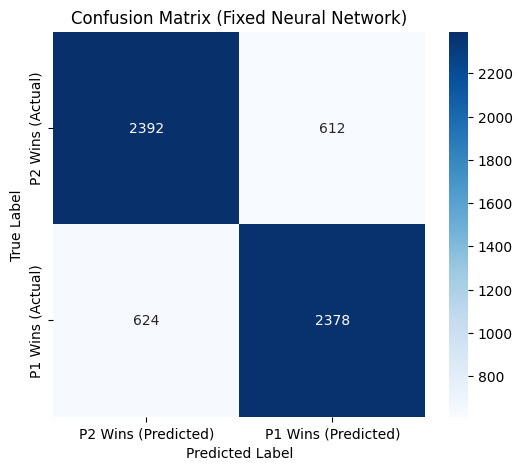


Feature importance for Neural Networks is typically analyzed differently (e.g., Permutation Importance).

--- Saving Model and Scaler ---
Neural Network model saved successfully to /Users/nikhilvankayala/TennisForcaster/models/tennis_match_predictor_nn_fixed.h5
StandardScaler saved successfully to /Users/nikhilvankayala/TennisForcaster/models/scaler_nn_fixed.joblib


In [74]:
# Cell 8: Model Training and Evaluation - Temporal Split with Fixed Neural Network (Keras)

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib # For saving the scaler

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler # For feature scaling
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization # Keep BatchNormalization
from keras.regularizers import l2 # Keep L2 regularization
from keras.callbacks import EarlyStopping # Optional: for early stopping during training

# Keras Tuner imports are REMOVED for this version


# Ensure ROLLING_WINDOW, EWMA_SPAN, H2H_RECENT_WINDOW, ROLLING_DERIVED_COLS are defined
# (best to define them once at the top of your notebook or in an initial setup cell)
# For safety, let's include them here again:
ROLLING_WINDOW = 10
EWMA_SPAN = 10
H2H_RECENT_WINDOW = 3
ROLLING_DERIVED_COLS = [
    'is_winner', '1st_serve_in_pct', '1st_serve_win_pct',
    '2nd_serve_win_pct',
    'break_point_save_pct', 'total_pts_won_on_serve_pct', 'break_pct'
]

# X and y are now expected to be defined from Cell 7

# Check if X is empty before proceeding (X and y are passed from Cell 7)
if len(X) == 0:
    print("Error: No data available for training after feature engineering and NaN drops.")
    print("Please review previous cells, especially the NaN handling and filtering.")
else:
    # Determine the split point for temporal validation (e.g., 80% for training, 20% for testing)
    split_idx = int(len(X) * 0.8)

    # Split data into training and test sets based on chronological order
    X_train = X.iloc[:split_idx]
    y_train = y.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_test = y.iloc[split_idx:]

    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Percentage of data used for training: {split_idx / len(X) * 100:.2f}%")

    # --- DIAGNOSTIC: X_train dtypes and content before Imputation ---
    print("\n--- DIAGNOSTIC: X_train dtypes before Imputation ---")
    print(X_train.dtypes)

    print("\n--- DIAGNOSTIC: X_train head before Imputation ---")
    display(X_train.head())

    print("\n--- DIAGNOSTIC: Non-numeric columns in X_train (and potential mixed types) ---")
    non_numeric_cols = X_train.select_dtypes(include=['object', 'category', 'datetime64[ns]']).columns
    if len(non_numeric_cols) > 0:
        print(f"Found non-numeric columns: {non_numeric_cols.tolist()}")
        for col in non_numeric_cols:
            print(f"\nSample values for non-numeric column '{col}':")
            try:
                converted_col = pd.to_numeric(X_train[col], errors='coerce')
                if converted_col.isnull().all():
                    print(f"  Column '{col}' appears to be entirely non-numeric strings/objects.")
                    print(X_train[col].dropna().unique()[:10])
                else:
                    if not X_train[col].apply(lambda x: isinstance(x, (pd.Series, list, tuple, dict))).any():
                        print(X_train[col].unique()[:10])
                    else:
                        print(f"  Column '{col}' contains Series objects or other unhashable types. Cannot display unique values directly.")
                        print(X_train[col].head())
            except Exception as e:
                print(f"  Could not process unique values for '{col}' due to error: {e}")
                print(X_train[col].head())
    else:
        print("No non-numeric columns found in X_train.")


    # --- CRITICAL: IMPUTATION (ONLY ON NUMERIC COLUMNS) ---
    print("\n--- Performing Imputation based on Training Data ---")

    imputer = SimpleImputer(strategy='mean')

    # Filter X_train to only include numeric columns for imputation
    X_train_numeric = X_train.select_dtypes(include=np.number)
    X_test_numeric = X_test.select_dtypes(include=np.number)

    # Fit imputer ONLY on the numeric part of the training data (X_train_numeric)
    imputer.fit(X_train_numeric)

    # Transform both numeric training and test data using the fitted imputer
    X_train_imputed = imputer.transform(X_train_numeric)
    X_test_imputed = imputer.transform(X_test_numeric)

    # Convert back to DataFrame to retain column names and index
    X_train = pd.DataFrame(X_train_imputed, columns=X_train_numeric.columns, index=X_train_numeric.index)
    X_test = pd.DataFrame(X_test_imputed, columns=X_test_numeric.columns, index=X_test_numeric.index)

    print("Imputation completed for training and test sets.")
    print(f"NaN count in X_train after imputation: {X_train.isnull().sum().sum()}")
    print(f"NaN count in X_test after imputation: {X_test.isnull().sum().sum()}")


    # --- FEATURE SCALING (CRITICAL FOR NEURAL NETWORKS) ---
    print("\n--- Performing Feature Scaling (StandardScaler) ---")
    scaler = StandardScaler()

    # Fit scaler ONLY on the training data
    scaler.fit(X_train)

    # Transform both training and test data
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled arrays back to DataFrames (optional, but good for consistency)
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    print("Feature scaling completed for training and test sets.")
    print(f"X_train (scaled) head:\n{X_train.head()}")
    print(f"X_train (scaled) describe:\n{X_train.describe()}")


    # --- FIXED NEURAL NETWORK MODEL DEFINITION ---
    print("\n--- Defining Fixed Neural Network Model ---")
    model = Sequential([
        # Input layer and first hidden layer with L2 regularization and Batch Normalization
        Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
        BatchNormalization(), # Added Batch Normalization
        Dropout(0.3), # Dropout for regularization

        # Second hidden layer with L2 regularization and Batch Normalization
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(), # Added Batch Normalization
        Dropout(0.3),

        # Third hidden layer with L2 regularization and Batch Normalization
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(), # Added Batch Normalization
        Dropout(0.2),

        # Output layer for binary classification
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', # Using default Adam learning rate
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    model.summary()


    # --- MODEL TRAINING ---
    print("\nStarting Neural Network model training...")
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100, # Can increase/decrease, early stopping will manage
        batch_size=32,
        validation_split=0.2, # Use a portion of training data for validation during training
        callbacks=[early_stopping],
        verbose=1
    )
    print("Neural Network model training completed.")


    # --- MODEL EVALUATION ---
    print("\n--- Model Evaluation (Fixed Neural Network) ---")
    loss, accuracy, auc_score = model.evaluate(X_test, y_test, verbose=0)

    print(f"Loss on Test Set: {loss:.4f}")
    print(f"Accuracy on Test Set: {accuracy:.4f}")
    print(f"ROC AUC Score on Test Set: {auc_score:.4f}")

    y_pred_proba = model.predict(X_test).ravel() # Get probabilities
    y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['P2 Wins (Predicted)', 'P1 Wins (Predicted)'],
                yticklabels=['P2 Wins (Actual)', 'P1 Wins (Actual)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Fixed Neural Network)')
    plt.show()

    print("\nFeature importance for Neural Networks is typically analyzed differently (e.g., Permutation Importance).")


    # --- SAVE THE TRAINED MODEL AND SCALER ---
    print("\n--- Saving Model and Scaler ---")
    models_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'models'))
    os.makedirs(models_dir, exist_ok=True)

    # Save Keras model (SavedModel format is recommended)
    model_save_path = os.path.join(models_dir, 'tennis_match_predictor_nn_fixed.h5') # Changed filename
    model.save(model_save_path)
    print(f"Neural Network model saved successfully to {model_save_path}")

    # Save the StandardScaler (CRITICAL for prediction)
    scaler_save_path = os.path.join(models_dir, 'scaler_nn_fixed.joblib') # Changed filename
    joblib.dump(scaler, scaler_save_path)
    print(f"StandardScaler saved successfully to {scaler_save_path}")


Feature Importances:
rank_points_diff                                         0.152252
rank_diff                                                0.135138
avg_win_pct_on_surface_diff_last10                       0.094575
avg_win_pct_diff_last10                                  0.073379
avg_total_pts_won_on_serve_pct_diff                      0.051840
height_diff                                              0.045001
age_diff                                                 0.044847
avg_break_pct_on_surface_diff_last10                     0.038590
avg_1st_serve_win_pct_diff                               0.037591
avg_total_pts_won_on_serve_pct_on_surface_diff_last10    0.035596
avg_2nd_serve_win_pct_diff                               0.033563
avg_1st_serve_in_pct_diff                                0.032893
avg_1st_serve_in_pct_on_surface_diff_last10              0.031763
h2h_matches_total                                        0.031076
avg_1st_serve_win_pct_on_surface_diff_last10          

/var/folders/lb/06xxjtz95sqgb8nkwb1ckhgr0000gn/T/ipykernel_10746/1292838021.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')


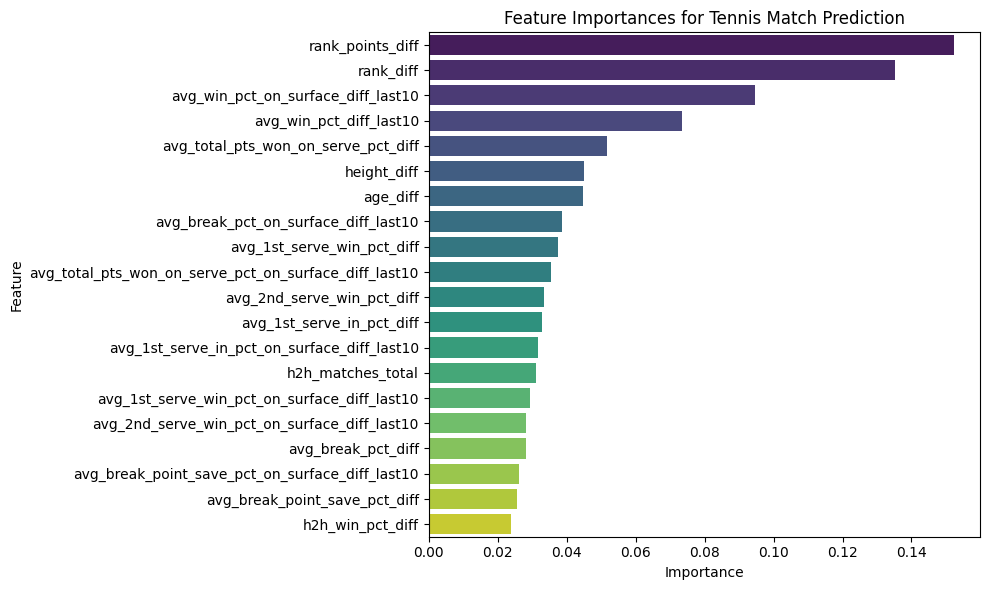

In [316]:
# Cell 10: Analyze Feature Importance (Optional)

# Ensure X has columns for feature importance
if not X.empty:
    feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

    print("\nFeature Importances:")
    print(feature_importances)

    # Optional: Visualize Feature Importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
    plt.title('Feature Importances for Tennis Match Prediction')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot calculate feature importances: X is empty.")


In [317]:
# Cell 11: Save the Trained Model

import joblib
import os

# Define the directory where models will be saved (as shown in your folder structure)
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True) # Create the directory if it doesn't exist

# Define the path to save the model
model_filename = os.path.join(models_dir, 'tennis_match_predictor.joblib')

# Save the model
joblib.dump(clf, model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to models/tennis_match_predictor.joblib
